In [2]:
import keras
from io import StringIO

Using TensorFlow backend.
Using TensorFlow backend.


In [3]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor
from keras import optimizers
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

In [4]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.max_rows=50

In [5]:
train = pd.read_csv('/home/ec2-user/SageMaker/train_FD001.txt', sep=" ", decimal=".", header=None)
test = pd.read_csv('/home/ec2-user/SageMaker/test_FD001.txt', sep=" ", decimal=".", header=None)
RUL = pd.read_csv('/home/ec2-user/SageMaker/RUL_FD001.txt', sep=" ", decimal=".", header=None)

In [6]:
train.drop(train.columns[[-1,-2]], axis=1, inplace=True)
test.drop(test.columns[[-1,-2]], axis=1, inplace=True)

In [7]:
cols = ['unit', 'cycles', 'op_setting1', 'op_setting2', 'op_setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
train.columns = cols
test.columns = cols

In [8]:
train.head()

,unit,cycles,op_setting1,op_setting2,op_setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.001,-0.000,100.000,518.670,641.820,1589.700,1400.600,14.620,...,521.660,2388.020,8138.620,8.419,0.030,392,2388,100.000,39.060,23.419
1,1,2,0.002,-0.000,100.000,518.670,642.150,1591.820,1403.140,14.620,...,522.280,2388.070,8131.490,8.432,0.030,392,2388,100.000,39.000,23.424
2,1,3,-0.004,0.000,100.000,518.670,642.350,1587.990,1404.200,14.620,...,522.420,2388.030,8133.230,8.418,0.030,390,2388,100.000,38.950,23.344
3,1,4,0.001,0.000,100.000,518.670,642.350,1582.790,1401.870,14.620,...,522.860,2388.080,8133.830,8.368,0.030,392,2388,100.000,38.880,23.374
4,1,5,-0.002,-0.000,100.000,518.670,642.370,1582.850,1406.220,14.620,...,522.190,2388.040,8133.800,8.429,0.030,393,2388,100.000,38.900,23.404


,unit,cycles,op_setting1,op_setting2,op_setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.001,-0.000,100.000,518.670,641.820,1589.700,1400.600,14.620,...,521.660,2388.020,8138.620,8.419,0.030,392,2388,100.000,39.060,23.419
1,1,2,0.002,-0.000,100.000,518.670,642.150,1591.820,1403.140,14.620,...,522.280,2388.070,8131.490,8.432,0.030,392,2388,100.000,39.000,23.424
2,1,3,-0.004,0.000,100.000,518.670,642.350,1587.990,1404.200,14.620,...,522.420,2388.030,8133.230,8.418,0.030,390,2388,100.000,38.950,23.344
3,1,4,0.001,0.000,100.000,518.670,642.350,1582.790,1401.870,14.620,...,522.860,2388.080,8133.830,8.368,0.030,392,2388,100.000,38.880,23.374
4,1,5,-0.002,-0.000,100.000,518.670,642.370,1582.850,1406.220,14.620,...,522.190,2388.040,8133.800,8.429,0.030,393,2388,100.000,38.900,23.404


In [9]:
# train.describe().transpose()

In [10]:
train.drop(['s1', 's5', 's10', 's16', 's18', 's19', 'op_setting3'], axis=1, inplace=True)
test.drop(['s1', 's5', 's10', 's16', 's18', 's19', 'op_setting3'], axis=1, inplace=True)

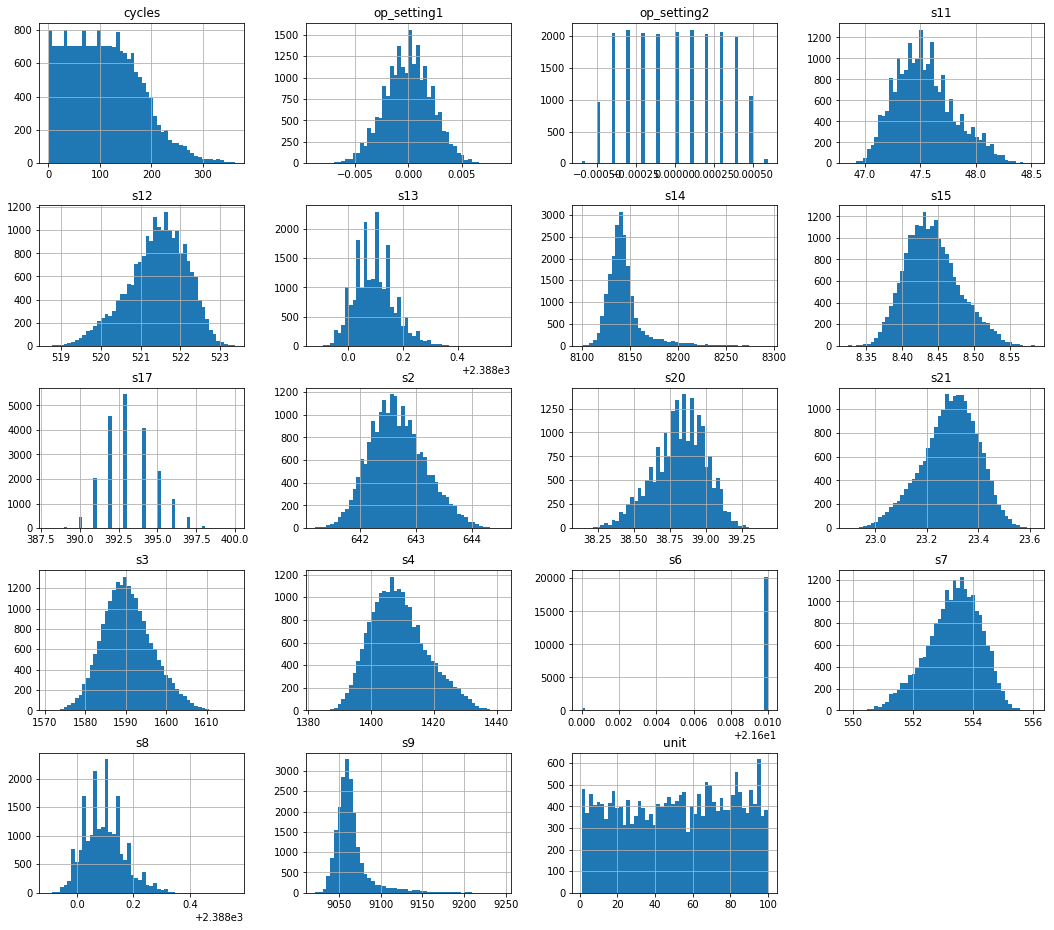

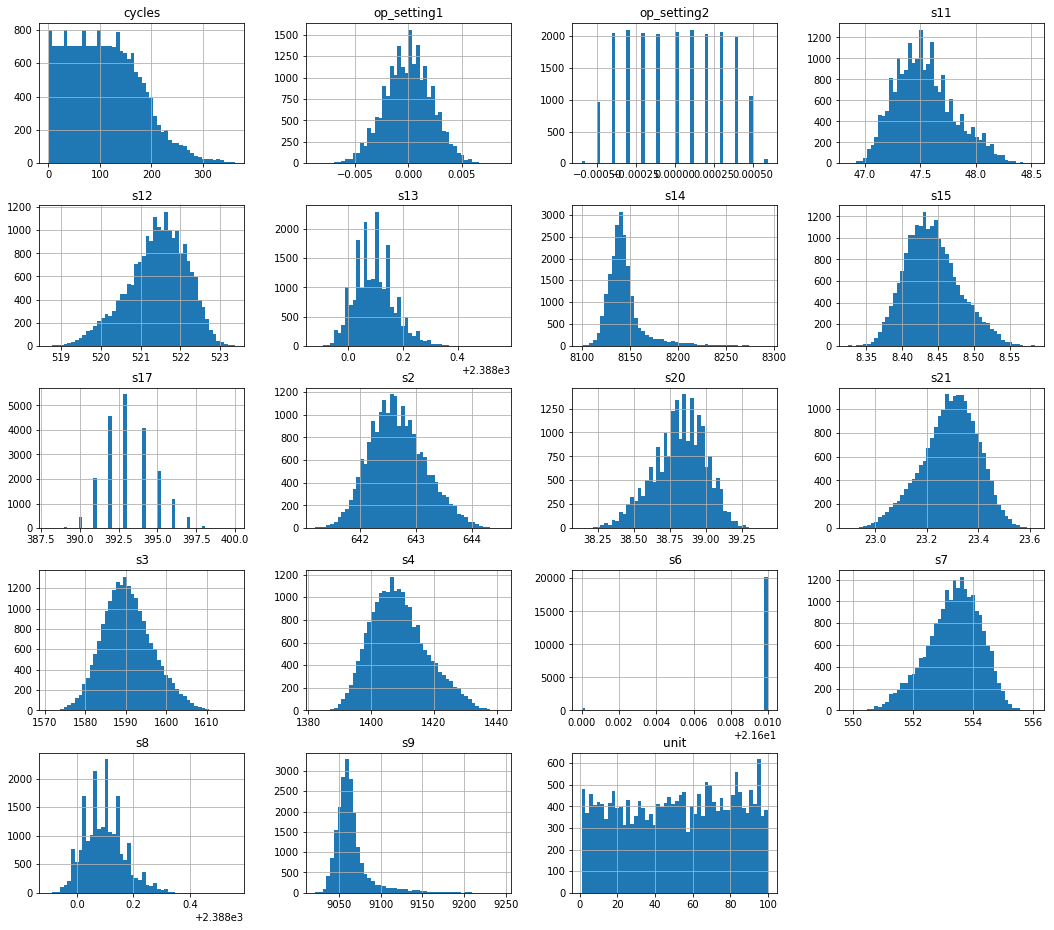

In [11]:
train.hist(bins=50, figsize=(18,16))
plt.show()

In [12]:
cyclestrain = train.groupby('unit', as_index=False)['cycles'].max()
cyclestest = test.groupby('unit', as_index=False)['cycles'].max()

In [13]:
cyclestrain.head() #czyli mamy 100 części, które przebyły x cykli

,unit,cycles
0,1,192
1,2,287
2,3,179
3,4,189
4,5,269


,unit,cycles
0,1,192
1,2,287
2,3,179
3,4,189
4,5,269


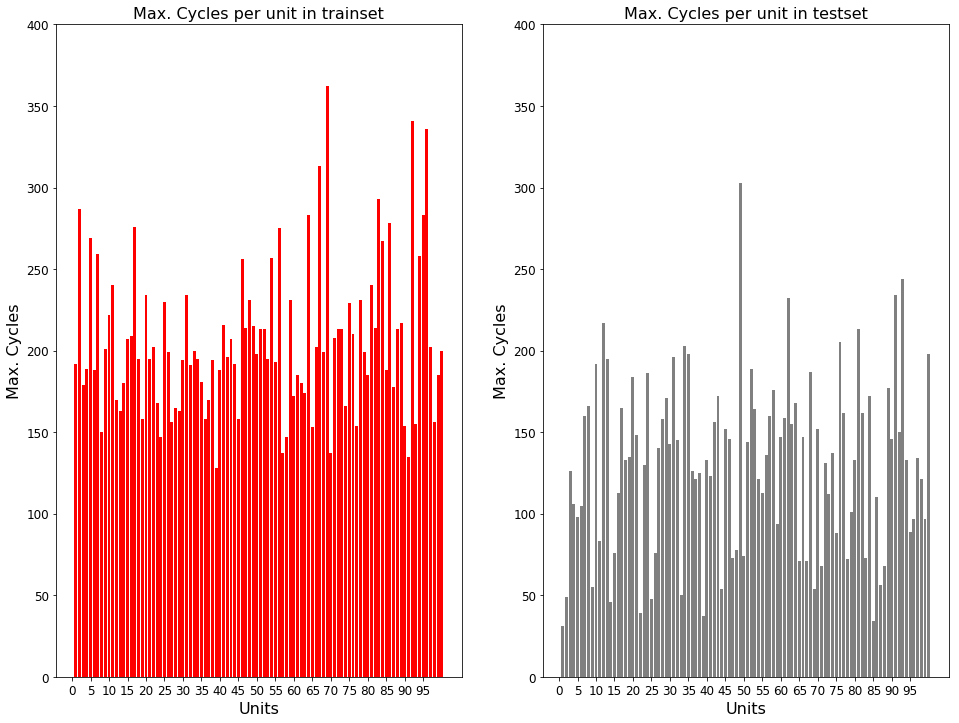

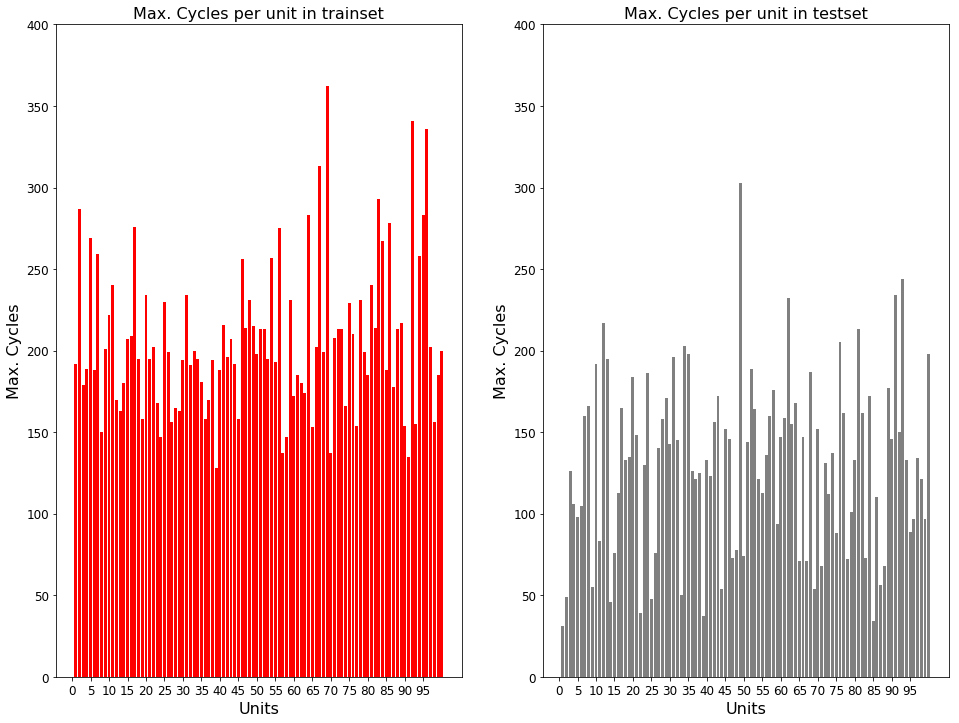

In [14]:
fig = plt.figure(figsize = (16,12))
fig.add_subplot(1,2,1)
bar_labels = list(cyclestrain['unit'])
bars = plt.bar(list(cyclestrain['unit']), cyclestrain['cycles'], color='red')
plt.ylim([0, 400])
plt.xlabel('Units', fontsize=16)
plt.ylabel('Max. Cycles', fontsize=16)
plt.title('Max. Cycles per unit in trainset', fontsize=16)
plt.xticks(np.arange(min(bar_labels)-1, max(bar_labels)-1, 5.0), fontsize=12)
plt.yticks(fontsize=12)
fig.add_subplot(1,2,2)
bars = plt.bar(list(cyclestest['unit']), cyclestest['cycles'], color='grey')
plt.ylim([0, 400])
plt.xlabel('Units', fontsize=16)
plt.ylabel('Max. Cycles', fontsize=16)
plt.title('Max. Cycles per unit in testset', fontsize=16)
plt.xticks(np.arange(min(bar_labels)-1, max(bar_labels)-1, 5.0), fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [15]:
train.head()

,unit,cycles,op_setting1,op_setting2,s2,s3,s4,s6,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21
0,1,1,-0.001,-0.000,641.820,1589.700,1400.600,21.610,554.360,2388.060,9046.190,47.470,521.660,2388.020,8138.620,8.419,392,39.060,23.419
1,1,2,0.002,-0.000,642.150,1591.820,1403.140,21.610,553.750,2388.040,9044.070,47.490,522.280,2388.070,8131.490,8.432,392,39.000,23.424
2,1,3,-0.004,0.000,642.350,1587.990,1404.200,21.610,554.260,2388.080,9052.940,47.270,522.420,2388.030,8133.230,8.418,390,38.950,23.344
3,1,4,0.001,0.000,642.350,1582.790,1401.870,21.610,554.450,2388.110,9049.480,47.130,522.860,2388.080,8133.830,8.368,392,38.880,23.374
4,1,5,-0.002,-0.000,642.370,1582.850,1406.220,21.610,554.000,2388.060,9055.150,47.280,522.190,2388.040,8133.800,8.429,393,38.900,23.404


,unit,cycles,op_setting1,op_setting2,s2,s3,s4,s6,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21
0,1,1,-0.001,-0.000,641.820,1589.700,1400.600,21.610,554.360,2388.060,9046.190,47.470,521.660,2388.020,8138.620,8.419,392,39.060,23.419
1,1,2,0.002,-0.000,642.150,1591.820,1403.140,21.610,553.750,2388.040,9044.070,47.490,522.280,2388.070,8131.490,8.432,392,39.000,23.424
2,1,3,-0.004,0.000,642.350,1587.990,1404.200,21.610,554.260,2388.080,9052.940,47.270,522.420,2388.030,8133.230,8.418,390,38.950,23.344
3,1,4,0.001,0.000,642.350,1582.790,1401.870,21.610,554.450,2388.110,9049.480,47.130,522.860,2388.080,8133.830,8.368,392,38.880,23.374
4,1,5,-0.002,-0.000,642.370,1582.850,1406.220,21.610,554.000,2388.060,9055.150,47.280,522.190,2388.040,8133.800,8.429,393,38.900,23.404


In [16]:
train = pd.merge(train, train.groupby('unit', as_index=False)['cycles'].max(), how='left', on='unit')
train.rename(columns={"cycles_x": "cycles", "cycles_y": "maxcycles"}, inplace=True)

In [17]:
train.head()

,unit,cycles,op_setting1,op_setting2,s2,s3,s4,s6,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,maxcycles
0,1,1,-0.001,-0.000,641.820,1589.700,1400.600,21.610,554.360,2388.060,9046.190,47.470,521.660,2388.020,8138.620,8.419,392,39.060,23.419,192
1,1,2,0.002,-0.000,642.150,1591.820,1403.140,21.610,553.750,2388.040,9044.070,47.490,522.280,2388.070,8131.490,8.432,392,39.000,23.424,192
2,1,3,-0.004,0.000,642.350,1587.990,1404.200,21.610,554.260,2388.080,9052.940,47.270,522.420,2388.030,8133.230,8.418,390,38.950,23.344,192
3,1,4,0.001,0.000,642.350,1582.790,1401.870,21.610,554.450,2388.110,9049.480,47.130,522.860,2388.080,8133.830,8.368,392,38.880,23.374,192
4,1,5,-0.002,-0.000,642.370,1582.850,1406.220,21.610,554.000,2388.060,9055.150,47.280,522.190,2388.040,8133.800,8.429,393,38.900,23.404,192


,unit,cycles,op_setting1,op_setting2,s2,s3,s4,s6,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,maxcycles
0,1,1,-0.001,-0.000,641.820,1589.700,1400.600,21.610,554.360,2388.060,9046.190,47.470,521.660,2388.020,8138.620,8.419,392,39.060,23.419,192
1,1,2,0.002,-0.000,642.150,1591.820,1403.140,21.610,553.750,2388.040,9044.070,47.490,522.280,2388.070,8131.490,8.432,392,39.000,23.424,192
2,1,3,-0.004,0.000,642.350,1587.990,1404.200,21.610,554.260,2388.080,9052.940,47.270,522.420,2388.030,8133.230,8.418,390,38.950,23.344,192
3,1,4,0.001,0.000,642.350,1582.790,1401.870,21.610,554.450,2388.110,9049.480,47.130,522.860,2388.080,8133.830,8.368,392,38.880,23.374,192
4,1,5,-0.002,-0.000,642.370,1582.850,1406.220,21.610,554.000,2388.060,9055.150,47.280,522.190,2388.040,8133.800,8.429,393,38.900,23.404,192


In [18]:
train['TTF'] = train['maxcycles'] - train['cycles']  #utworzyło ostatnią kolumnę, która mówi ILE JESZCZE PRZEŻYJE część

In [19]:
train.head()

,unit,cycles,op_setting1,op_setting2,s2,s3,s4,s6,s7,s8,...,s11,s12,s13,s14,s15,s17,s20,s21,maxcycles,TTF
0,1,1,-0.001,-0.000,641.820,1589.700,1400.600,21.610,554.360,2388.060,...,47.470,521.660,2388.020,8138.620,8.419,392,39.060,23.419,192,191
1,1,2,0.002,-0.000,642.150,1591.820,1403.140,21.610,553.750,2388.040,...,47.490,522.280,2388.070,8131.490,8.432,392,39.000,23.424,192,190
2,1,3,-0.004,0.000,642.350,1587.990,1404.200,21.610,554.260,2388.080,...,47.270,522.420,2388.030,8133.230,8.418,390,38.950,23.344,192,189
3,1,4,0.001,0.000,642.350,1582.790,1401.870,21.610,554.450,2388.110,...,47.130,522.860,2388.080,8133.830,8.368,392,38.880,23.374,192,188
4,1,5,-0.002,-0.000,642.370,1582.850,1406.220,21.610,554.000,2388.060,...,47.280,522.190,2388.040,8133.800,8.429,393,38.900,23.404,192,187


,unit,cycles,op_setting1,op_setting2,s2,s3,s4,s6,s7,s8,...,s11,s12,s13,s14,s15,s17,s20,s21,maxcycles,TTF
0,1,1,-0.001,-0.000,641.820,1589.700,1400.600,21.610,554.360,2388.060,...,47.470,521.660,2388.020,8138.620,8.419,392,39.060,23.419,192,191
1,1,2,0.002,-0.000,642.150,1591.820,1403.140,21.610,553.750,2388.040,...,47.490,522.280,2388.070,8131.490,8.432,392,39.000,23.424,192,190
2,1,3,-0.004,0.000,642.350,1587.990,1404.200,21.610,554.260,2388.080,...,47.270,522.420,2388.030,8133.230,8.418,390,38.950,23.344,192,189
3,1,4,0.001,0.000,642.350,1582.790,1401.870,21.610,554.450,2388.110,...,47.130,522.860,2388.080,8133.830,8.368,392,38.880,23.374,192,188
4,1,5,-0.002,-0.000,642.370,1582.850,1406.220,21.610,554.000,2388.060,...,47.280,522.190,2388.040,8133.800,8.429,393,38.900,23.404,192,187


In [20]:
scaler = MinMaxScaler()

In [21]:
ntrain = train.copy()

In [22]:
ntrain.iloc[:,2:19].head()

,op_setting1,op_setting2,s2,s3,s4,s6,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21
0,-0.001,-0.000,641.820,1589.700,1400.600,21.610,554.360,2388.060,9046.190,47.470,521.660,2388.020,8138.620,8.419,392,39.060,23.419
1,0.002,-0.000,642.150,1591.820,1403.140,21.610,553.750,2388.040,9044.070,47.490,522.280,2388.070,8131.490,8.432,392,39.000,23.424
2,-0.004,0.000,642.350,1587.990,1404.200,21.610,554.260,2388.080,9052.940,47.270,522.420,2388.030,8133.230,8.418,390,38.950,23.344
3,0.001,0.000,642.350,1582.790,1401.870,21.610,554.450,2388.110,9049.480,47.130,522.860,2388.080,8133.830,8.368,392,38.880,23.374
4,-0.002,-0.000,642.370,1582.850,1406.220,21.610,554.000,2388.060,9055.150,47.280,522.190,2388.040,8133.800,8.429,393,38.900,23.404


,op_setting1,op_setting2,s2,s3,s4,s6,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21
0,-0.001,-0.000,641.820,1589.700,1400.600,21.610,554.360,2388.060,9046.190,47.470,521.660,2388.020,8138.620,8.419,392,39.060,23.419
1,0.002,-0.000,642.150,1591.820,1403.140,21.610,553.750,2388.040,9044.070,47.490,522.280,2388.070,8131.490,8.432,392,39.000,23.424
2,-0.004,0.000,642.350,1587.990,1404.200,21.610,554.260,2388.080,9052.940,47.270,522.420,2388.030,8133.230,8.418,390,38.950,23.344
3,0.001,0.000,642.350,1582.790,1401.870,21.610,554.450,2388.110,9049.480,47.130,522.860,2388.080,8133.830,8.368,392,38.880,23.374
4,-0.002,-0.000,642.370,1582.850,1406.220,21.610,554.000,2388.060,9055.150,47.280,522.190,2388.040,8133.800,8.429,393,38.900,23.404


In [23]:
ntrain.iloc[:,2:19] = scaler.fit_transform(ntrain.iloc[:,2:19]) #skalowanie kolumn od ustawień do ostatniego sensora

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [24]:
ntest = test.copy()
pd.DataFrame(ntest.columns).transpose()
ntest.iloc[:,2:19] = scaler.transform(ntest.iloc[:,2:19]) #skalowanie testowych zmiennych

In [25]:
ntest.head()

,unit,cycles,op_setting1,op_setting2,s2,s3,s4,s6,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21
0,1,1,0.632,0.750,0.545,0.311,0.269,1.000,0.652,0.212,0.128,0.208,0.646,0.221,0.132,0.309,0.333,0.558,0.662
1,1,2,0.345,0.250,0.151,0.380,0.222,1.000,0.805,0.167,0.147,0.387,0.740,0.265,0.205,0.213,0.417,0.682,0.687
2,1,3,0.517,0.583,0.377,0.347,0.322,1.000,0.686,0.227,0.158,0.387,0.699,0.221,0.156,0.459,0.417,0.729,0.721
3,1,4,0.741,0.500,0.370,0.285,0.408,1.000,0.680,0.197,0.106,0.256,0.574,0.250,0.170,0.257,0.250,0.667,0.662
4,1,5,0.580,0.500,0.392,0.352,0.332,1.000,0.694,0.167,0.102,0.274,0.738,0.221,0.153,0.301,0.167,0.659,0.716


,unit,cycles,op_setting1,op_setting2,s2,s3,s4,s6,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21
0,1,1,0.632,0.750,0.545,0.311,0.269,1.000,0.652,0.212,0.128,0.208,0.646,0.221,0.132,0.309,0.333,0.558,0.662
1,1,2,0.345,0.250,0.151,0.380,0.222,1.000,0.805,0.167,0.147,0.387,0.740,0.265,0.205,0.213,0.417,0.682,0.687
2,1,3,0.517,0.583,0.377,0.347,0.322,1.000,0.686,0.227,0.158,0.387,0.699,0.221,0.156,0.459,0.417,0.729,0.721
3,1,4,0.741,0.500,0.370,0.285,0.408,1.000,0.680,0.197,0.106,0.256,0.574,0.250,0.170,0.257,0.250,0.667,0.662
4,1,5,0.580,0.500,0.392,0.352,0.332,1.000,0.694,0.167,0.102,0.274,0.738,0.221,0.153,0.301,0.167,0.659,0.716


In [26]:
# fig = plt.figure(figsize = (8, 8))
# fig.add_subplot(1,2,1)
# plt.plot(train[train.unit==1].s2)
# plt.plot(test[test.unit==1].s2)
# plt.legend(['Train','Test'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3, mode="expand", borderaxespad=0)
# plt.ylabel('Original unit')
# fig.add_subplot(1,2,2)
# plt.plot(ntrain[ntrain.unit==1].s2)
# plt.plot(ntest[ntest.unit==1].s2)
# plt.legend(['Scaled Train','Scaled Test'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3, mode="expand", borderaxespad=0)
# plt.ylabel('Scaled unit')
# plt.show()

In [27]:
def fractionTTF(dat,q):
    return(dat.TTF[q]-dat.TTF.min()) / float(dat.TTF.max()-dat.TTF.min())
fTTFz = []
fTTF = []
for i in range(train['unit'].min(),train['unit'].max()+1):  #dla każdej części 
    dat=train[train.unit==i]
    dat = dat.reset_index(drop=True)
    for q in range(len(dat)):
        fTTFz = fractionTTF(dat, q)
        fTTF.append(fTTFz)
ntrain['fTTF'] = fTTF   #dodanie kolumny fTTF, czyli od 1-0 ile proporcjonalnie zostało jeszcze czasu (skalowanie)

In [28]:
ntrain.head()

,unit,cycles,op_setting1,op_setting2,s2,s3,s4,s6,s7,s8,...,s12,s13,s14,s15,s17,s20,s21,maxcycles,TTF,fTTF
0,1,1,0.460,0.167,0.184,0.407,0.310,1.000,0.726,0.242,...,0.633,0.206,0.200,0.364,0.333,0.713,0.725,192,191,1.000
1,1,2,0.609,0.250,0.283,0.453,0.353,1.000,0.628,0.212,...,0.765,0.279,0.163,0.411,0.333,0.667,0.731,192,190,0.995
2,1,3,0.253,0.750,0.343,0.370,0.371,1.000,0.710,0.273,...,0.795,0.221,0.172,0.357,0.167,0.628,0.621,192,189,0.990
3,1,4,0.540,0.500,0.343,0.256,0.331,1.000,0.741,0.318,...,0.889,0.294,0.175,0.167,0.333,0.574,0.662,192,188,0.984
4,1,5,0.391,0.333,0.349,0.257,0.405,1.000,0.668,0.242,...,0.746,0.235,0.175,0.402,0.417,0.589,0.705,192,187,0.979


,unit,cycles,op_setting1,op_setting2,s2,s3,s4,s6,s7,s8,...,s12,s13,s14,s15,s17,s20,s21,maxcycles,TTF,fTTF
0,1,1,0.460,0.167,0.184,0.407,0.310,1.000,0.726,0.242,...,0.633,0.206,0.200,0.364,0.333,0.713,0.725,192,191,1.000
1,1,2,0.609,0.250,0.283,0.453,0.353,1.000,0.628,0.212,...,0.765,0.279,0.163,0.411,0.333,0.667,0.731,192,190,0.995
2,1,3,0.253,0.750,0.343,0.370,0.371,1.000,0.710,0.273,...,0.795,0.221,0.172,0.357,0.167,0.628,0.621,192,189,0.990
3,1,4,0.540,0.500,0.343,0.256,0.331,1.000,0.741,0.318,...,0.889,0.294,0.175,0.167,0.333,0.574,0.662,192,188,0.984
4,1,5,0.391,0.333,0.349,0.257,0.405,1.000,0.668,0.242,...,0.746,0.235,0.175,0.402,0.417,0.589,0.705,192,187,0.979


In [29]:
X_train = ntrain.values[:,1:19]  #Naszymi X są pomiary z sensorów
Y_train = ntrain.values[:, 21] #NAszym Y jest wyskalowany pozostały czas
X_test = ntest.values[:,1:19] #do przetestowania są wartości pomiarów z testu

In [32]:
#1 model
model = Sequential() #PARAMETRY SIECI: 18 - ilość wejść (tyle mamy sensorów), 6 - ilość neuronów w sieci ukrytej, 
model.add(Dense(6, input_dim=18, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mean_squared_error', optimizer='adam')

#2 model
# model = Sequential([
#         keras.layers.Dense(24, activation='relu', input_dim=18),
#         keras.layers.Dense(24, activation='relu'),
#         keras.layers.Dense(24, activation='relu'),
#         keras.layers.Dense(1)
#     ])

# optimizer = optimizers.RMSprop(0.01) #test optimizer
# model.compile(loss='mse',
#                 optimizer=optimizer,
#                 metrics=['mae'])

#3 model: sieć rekurencyjna
#LSTM: (batch, time_steps, features)
# X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
# model = Sequential()
# model.add(LSTM(128, input_shape=(1,18), return_sequences=True))
# model.add(Dense(1))
# model.add(Activation('softmax'))

# optimizer = optimizers.RMSprop(0.01)
# model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer)

model.fit(X_train, Y_train, epochs=60)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/120
Epoch 1/120
20631/20631 [==============================] - 2s 75us/step - loss: 0.0493
Epoch 2/120
Epoch 2/120
20631/20631 [==============================] - 1s 55us/step - loss: 0.0091
Epoch 3/120
20631/20631 [==============================] - 1s 55us/step - loss: 0.0091
Epoch 3/120
20631/20631 [==============================] - 1s 55us/step - loss: 0.0083
Epoch 4/120
20631/20631 [==============================] - 1s 55us/step - loss: 0.0083
Epoch 4/120
20631/20631 [==============================] - 1s 56us/step - loss: 0.0081
Epoch 5/120
20631/20631 [==============================] - 1s 56us/step - loss: 0.0081
Epoch 5/120
20631/20631 [==============================] - 1s 56us/step - loss: 0.0080
Epoch 6/120
20631/20631 [===============

20631/20631 [==============================] - 1s 56us/step - loss: 0.0045
Epoch 75/120
20631/20631 [==============================] - 1s 56us/step - loss: 0.0045
Epoch 76/120
20631/20631 [==============================] - 1s 56us/step - loss: 0.0045
Epoch 76/120
20631/20631 [==============================] - 1s 56us/step - loss: 0.0045
Epoch 77/120
20631/20631 [==============================] - 1s 56us/step - loss: 0.0045
Epoch 78/120
20631/20631 [==============================] - 1s 56us/step - loss: 0.0045
Epoch 79/120
20631/20631 [==============================] - 1s 56us/step - loss: 0.0045
Epoch 80/120
20631/20631 [==============================] - 1s 56us/step - loss: 0.0045
Epoch 81/120
20631/20631 [==============================] - 1s 56us/step - loss: 0.0045
Epoch 82/120
20631/20631 [==============================] - 1s 56us/step - loss: 0.0045
Epoch 81/120
20631/20631 [==============================] - 1s 56us/step - loss: 0.0045
Epoch 82/120
20631/20631 [===================

20631/20631 [==============================] - 1s 55us/step - loss: 0.0044


In [33]:
score = model.predict(X_test)
print(score)

[[0.9723796 ]
 [0.97238743]
 [0.9753723 ]
 ...
 [0.1415109 ]
 [0.12722191]
 [0.06837273]]
[[0.9723796 ]
 [0.97238743]
 [0.9753723 ]
 ...
 [0.1415109 ]
 [0.12722191]
 [0.06837273]]


13096

13096

In [34]:
test = pd.merge(test, test.groupby('unit', as_index=False)['cycles'].max(), how='left', on='unit')
test.rename(columns={"cycles_x": "cycles", "cycles_y": "maxcycles"}, inplace=True)
test = test[:10000].copy()

In [35]:
len(score)

13096

13096

In [36]:
test['score']= score[:10000]

def totcycles(data):
    return(data['cycles'] / (1-data['score']))

test['maxpredcycles'] = totcycles(test)

In [37]:
test.head()

,unit,cycles,op_setting1,op_setting2,s2,s3,s4,s6,s7,s8,...,s12,s13,s14,s15,s17,s20,s21,maxcycles,score,maxpredcycles
0,1,1,0.002,0.000,643.020,1585.290,1398.210,21.610,553.900,2388.040,...,521.720,2388.030,8125.550,8.405,392,38.860,23.373,31,0.972,36.205
1,1,2,-0.003,-0.000,641.710,1588.450,1395.420,21.610,554.850,2388.010,...,522.160,2388.060,8139.620,8.380,393,39.020,23.392,31,0.972,72.431
2,1,3,0.000,0.000,642.460,1586.940,1401.340,21.610,554.110,2388.050,...,521.970,2388.030,8130.100,8.444,393,39.080,23.417,31,0.975,121.814
3,1,4,0.004,0.000,642.440,1584.120,1406.420,21.610,554.070,2388.030,...,521.380,2388.050,8132.900,8.392,391,39.000,23.374,31,0.960,100.081
4,1,5,0.001,0.000,642.510,1587.190,1401.920,21.610,554.160,2388.010,...,522.150,2388.030,8129.540,8.403,390,38.990,23.413,31,0.966,149.135


,unit,cycles,op_setting1,op_setting2,s2,s3,s4,s6,s7,s8,...,s12,s13,s14,s15,s17,s20,s21,maxcycles,score,maxpredcycles
0,1,1,0.002,0.000,643.020,1585.290,1398.210,21.610,553.900,2388.040,...,521.720,2388.030,8125.550,8.405,392,38.860,23.373,31,0.972,36.205
1,1,2,-0.003,-0.000,641.710,1588.450,1395.420,21.610,554.850,2388.010,...,522.160,2388.060,8139.620,8.380,393,39.020,23.392,31,0.972,72.431
2,1,3,0.000,0.000,642.460,1586.940,1401.340,21.610,554.110,2388.050,...,521.970,2388.030,8130.100,8.444,393,39.080,23.417,31,0.975,121.814
3,1,4,0.004,0.000,642.440,1584.120,1406.420,21.610,554.070,2388.030,...,521.380,2388.050,8132.900,8.392,391,39.000,23.374,31,0.960,100.081
4,1,5,0.001,0.000,642.510,1587.190,1401.920,21.610,554.160,2388.010,...,522.150,2388.030,8129.540,8.403,390,38.990,23.413,31,0.966,149.135


In [38]:
def RULfunction(data):
    return(data['maxpredcycles'] - data['maxcycles'])
test['RUL'] = RULfunction(test)

In [39]:
test.head()

,unit,cycles,op_setting1,op_setting2,s2,s3,s4,s6,s7,s8,...,s13,s14,s15,s17,s20,s21,maxcycles,score,maxpredcycles,RUL
0,1,1,0.002,0.000,643.020,1585.290,1398.210,21.610,553.900,2388.040,...,2388.030,8125.550,8.405,392,38.860,23.373,31,0.972,36.205,5.205
1,1,2,-0.003,-0.000,641.710,1588.450,1395.420,21.610,554.850,2388.010,...,2388.060,8139.620,8.380,393,39.020,23.392,31,0.972,72.431,41.431
2,1,3,0.000,0.000,642.460,1586.940,1401.340,21.610,554.110,2388.050,...,2388.030,8130.100,8.444,393,39.080,23.417,31,0.975,121.814,90.814
3,1,4,0.004,0.000,642.440,1584.120,1406.420,21.610,554.070,2388.030,...,2388.050,8132.900,8.392,391,39.000,23.374,31,0.960,100.081,69.081
4,1,5,0.001,0.000,642.510,1587.190,1401.920,21.610,554.160,2388.010,...,2388.030,8129.540,8.403,390,38.990,23.413,31,0.966,149.135,118.135


,unit,cycles,op_setting1,op_setting2,s2,s3,s4,s6,s7,s8,...,s13,s14,s15,s17,s20,s21,maxcycles,score,maxpredcycles,RUL
0,1,1,0.002,0.000,643.020,1585.290,1398.210,21.610,553.900,2388.040,...,2388.030,8125.550,8.405,392,38.860,23.373,31,0.972,36.205,5.205
1,1,2,-0.003,-0.000,641.710,1588.450,1395.420,21.610,554.850,2388.010,...,2388.060,8139.620,8.380,393,39.020,23.392,31,0.972,72.431,41.431
2,1,3,0.000,0.000,642.460,1586.940,1401.340,21.610,554.110,2388.050,...,2388.030,8130.100,8.444,393,39.080,23.417,31,0.975,121.814,90.814
3,1,4,0.004,0.000,642.440,1584.120,1406.420,21.610,554.070,2388.030,...,2388.050,8132.900,8.392,391,39.000,23.374,31,0.960,100.081,69.081
4,1,5,0.001,0.000,642.510,1587.190,1401.920,21.610,554.160,2388.010,...,2388.030,8129.540,8.403,390,38.990,23.413,31,0.966,149.135,118.135


In [40]:
t = test.columns == 'RUL'
ind = [i for i, x in enumerate(t) if x]
#print(ind)
predictedRUL = []
for i in range(test.unit.min(), test.unit.max()+1):
    npredictedRUL=test[test.unit==i].iloc[test[test.unit==i].cycles.max()-1,ind]
    predictedRUL.append(npredictedRUL)
predictedRUL[0:10]

xtrueRUL = list(RUL.loc[:,0])
otrueRUL = []
for i in range(0,len(xtrueRUL)):
    otrueRUL = np.concatenate((otrueRUL, list(reversed(np.arange(xtrueRUL[i])))))
xpredictedRUL = list(round(x) for x in predictedRUL)
opredictedRUL = []
# print(xpredictedRUL)
# print(test[test.unit==1])

for i in range(0,len(xpredictedRUL)):
    opredictedRUL = np.concatenate((opredictedRUL, list(reversed(np.arange(int(xpredictedRUL[i]))))))
#print(opredictedRUL)
mx = 1000

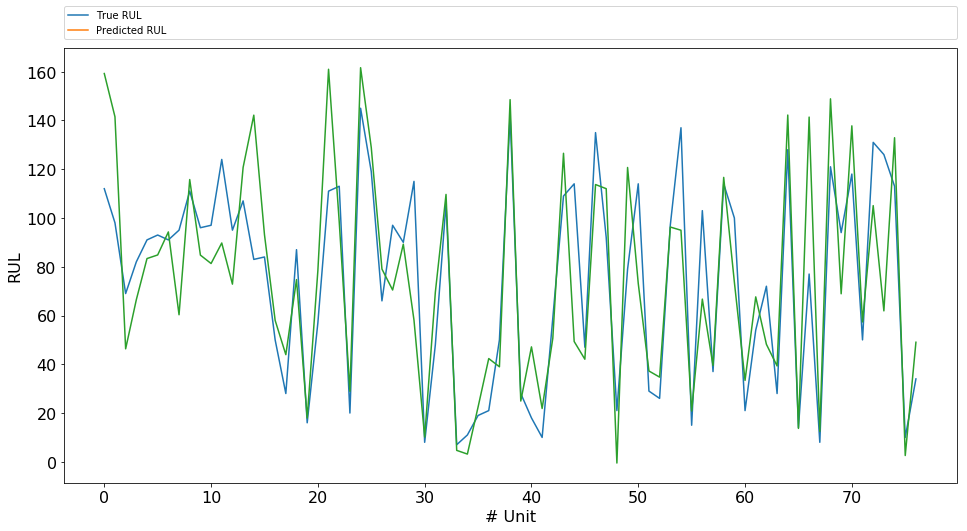

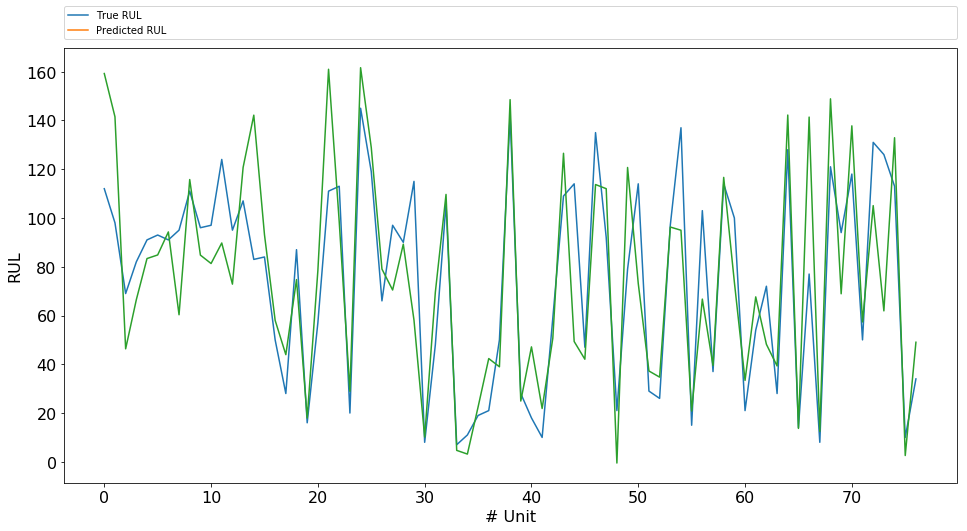

In [41]:
plt.figure(figsize = (16, 8))
plt.plot(RUL[:77])
plt.plot(predictedRUL)
plt.xlabel('# Unit', fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('RUL', fontsize=16)
plt.yticks(fontsize=16)
plt.legend(['True RUL','Predicted RUL'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3, mode="expand", borderaxespad=0)
plt.show()
RUL = RUL[:77]

In [42]:
from sklearn.metrics import mean_squared_error
import math
mse = mean_squared_error(RUL[0], xpredictedRUL)
print(math.sqrt(mse))

25.101870370629676
25.101870370629676


In [43]:
#Wyniki sieci:
#18 input/2warstwy, 6/1 dense, normal kernel, 3 epoki: adam 45.20860738640577
#18 input/2warstwy, 6/1 dense, normal kernel, 200 epok: adam 29.12534487839954
#18 input/4warstwy, 24/24/24/1 dense, 3 epoki: optimizer z learning rate - 0.001: 80.01436559330268
#18 input/4warstwy, 24/24/24/1 dense, 200 epoki: optimizer RMSprop 0.001: 210.03917383539326
#18 input/4warstwy, 24/24/24/1 dense, 120 epoki: optimizer adam: 25.92697036307544
#18 input/4warstwy, 24/24/24/1 dense, 120 epoki: optimizer RMSprop 0.01: 24.894061253927326

In [ ]:
'''Sekcja SageMaker'''
#Zapisywanie modelu keras:
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
import numpy
import os
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5") #Zapisuje

In [78]:
#IMPORT modelu do S3 
import tarfile
with tarfile.open('model.tar.gz', mode='w:gz') as archive:
    archive.add('model.h5', recursive=True) #wagi modelu
    archive.add('model.json') #model

sagemaker_session = sagemaker.Session()
inputs = sagemaker_session.upload_data(bucket="neurosys-intern", path='model.tar.gz', key_prefix='Modele')

In [52]:
def upload_to_s3(file):
    s3 = boto3.resource('s3')
    data = open(file, "rb")
    s3.Bucket("neurosys-intern").put_object(Key=file, Body=data)

upload_to_s3('model.tar.gz') #Zapisywanie plików na S3

In [ ]:
predictor = sagemaker_model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')